# Convexity and Optimization (Convexidade e Otimização)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Cross-Validation (Validação Cruzada)
  * The Validation Set Approach (A Abordagem do Conjunto de Validação)
  * Leave-One-Out Cross-Validation (Validação Cruzada Leave-One-Out)
  * k-Fold Cross-Validation (Validação Cruzada k-Fold)
* The Bootstrap

### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 5***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman : 
  * Capítulo 7

***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

### 1. Introdução



In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import autograd.numpy as np
from autograd import grad
import seaborn as sns

# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [2]:
# Function to plot errors
def error_plot(ys, yscale='log'):
    plt.figure()
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys)

### 2. Gradiente descendente

Começamos com uma implementação básica da descida do gradiente projetada.

In [5]:
def gradient_descent(init, steps, grad, proj=lambda x: x):
    """Projected gradient descent.
    
    Inputs:
        initial: starting point
        steps: list of scalar step sizes
        grad: function mapping points to gradients
        proj (optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

Observe que esta implementação mantém todos os pontos computados ao longo do caminho. Isso claramente não é o que você faria em instâncias grandes. Fazemos isso para fins ilustrativos, para podermos inspecionar facilmente a sequência de pontos computada.

### 2.1. Aquecimento: Otimizando uma equação quadrática

Como um exemplo de brinquedo, vamos otimizar $$f(x)=\frac12|x|^2,$$ que tem o mapa de gradiente $\nabla f(x)=x.$
 
que tem o mapa de gradiente

In [6]:
def quadratic(x):
    return 0.5*x.dot(x)

def quadratic_gradient(x):
    return x

Observe que a função é 1-suave e 1-fortemente convexa. Nossos teoremas sugerem, então, que usemos um passo constante de 1. Se você pensar bem, para esse passo, o algoritmo encontrará a solução ótima em apenas um passo.
-suave e
- fortemente convexo. Nossos teoremas sugeririam então que usássemos um passo de tamanho constante de
Se você pensar bem, para esse tamanho de passo o algoritmo encontrará a solução ótima em apenas um passo.

In [7]:
x0 = np.random.normal(0, 1, (1000))
_, x1 = gradient_descent(x0, [1.0], quadratic_gradient)

De fato, sim.

In [8]:
x1.all() == 0

True

Digamos que não temos a taxa de aprendizagem correta.

In [9]:
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient)

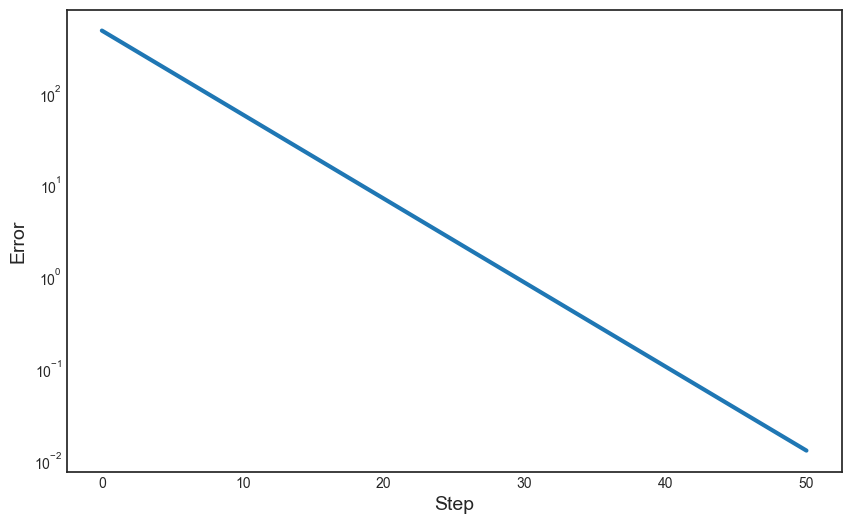

In [10]:
# Plot errors along steps
error_plot([quadratic(x) for x in xs])

### 3. Otimização Restrita


Digamos que queremos otimizar a função dentro de um subespaço afim. Lembre-se de que subespaços afins são conjuntos convexos. Abaixo, escolhemos um subespaço afim aleatório de baixa dimensão $b+U$ e definimos o operador de projeção linear correspondente.
e definir o operador de projeção linear correspondente.

In [11]:
# U is an orthonormal basis of a random 100-dimensional subspace.
U = np.linalg.qr(np.random.normal(0, 1, (1000, 100)))[0]
b = np.random.normal(0, 1, 1000)

def proj(x):
    """Projection of x onto an affine subspace"""
    return b + U.dot(U.T).dot(x-b)

In [12]:
x0 = np.random.normal(0, 1, (1000))
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient, proj)
# the optimal solution is the projection of the origin
x_opt = proj(0)

Vamos traçar os resultados.

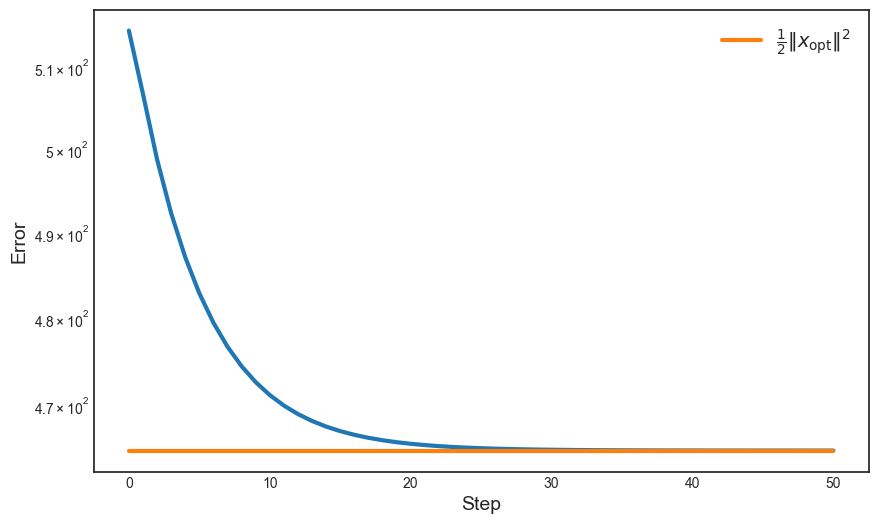

In [13]:
error_plot([quadratic(x) for x in xs])
plt.plot(range(len(xs)), [quadratic(x_opt)]*len(xs),
        label='$\\frac{1}{2}|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend();

A linha laranja mostra o erro ótimo, que o algoritmo alcança rapidamente.

As iterações também convergem para a solução ótima no domínio, como mostra o gráfico a seguir.

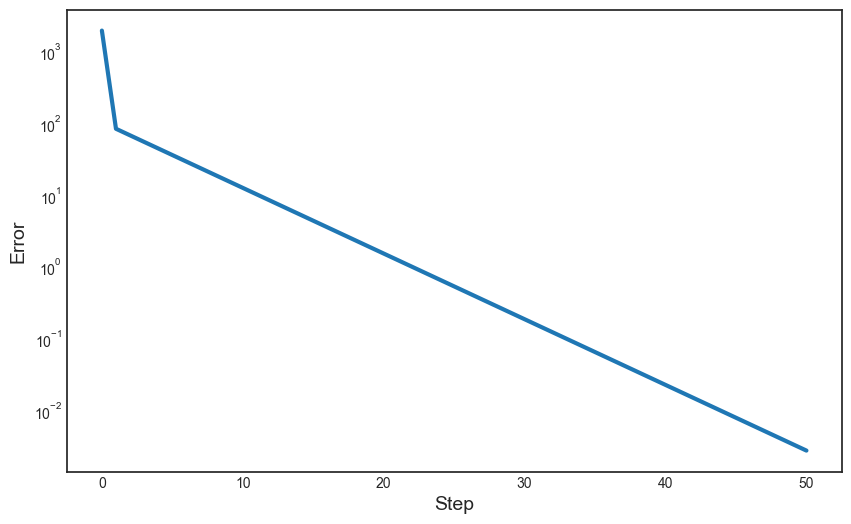

In [14]:
error_plot([np.linalg.norm(x_opt-x)**2 for x in xs])

### 5. Mínimos Quadrados


Uma das ferramentas de análise de dados mais fundamentais é a análise de mínimos quadrados lineares . Dada uma matriz $A$ m vezes n e um vetor $b$, nosso objetivo é encontrar um vetor $x\in\mathbb{R}^n$ que minimize o seguinte objetivo:
matriz
e um vetor
nosso objetivo é encontrar um vetor
que minimiza o seguinte objetivo:

$$f(x) = \frac 1{2m}\sum_{i=1}^m (a_i^\top x - b_j)^2 =\frac1{2m}\|Ax-b\|^2$$
 
 
 

Podemos verificar que $\nabla f(x) = A^\top(Ax-b)$ e $\nabla^2 f(x) = A^\top A.$
e 

Portanto, o objetivo é $\beta$-suave com $\beta=\lambda_{\mathrm{max}}(A^\top A)$, e $\alpha$-fortemente convexo com $\alpha=\lambda_{\mathrm{min}}(A^\top A)$.
-suave com 
, e
-fortemente convexo com
.

In [15]:
def least_squares(A, b, x):
    """Least squares objective."""
    return (0.5/m) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    """Gradient of least squares objective at x."""
    return A.T.dot(A.dot(x)-b)/m

Caso sobredeterminado $m\ge n$

In [16]:
m, n = 1000, 100
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
noise = np.random.normal(0, 0.1, m)
b = A.dot(x_opt) + noise
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)

### Convergência em Objetivos

In [17]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)

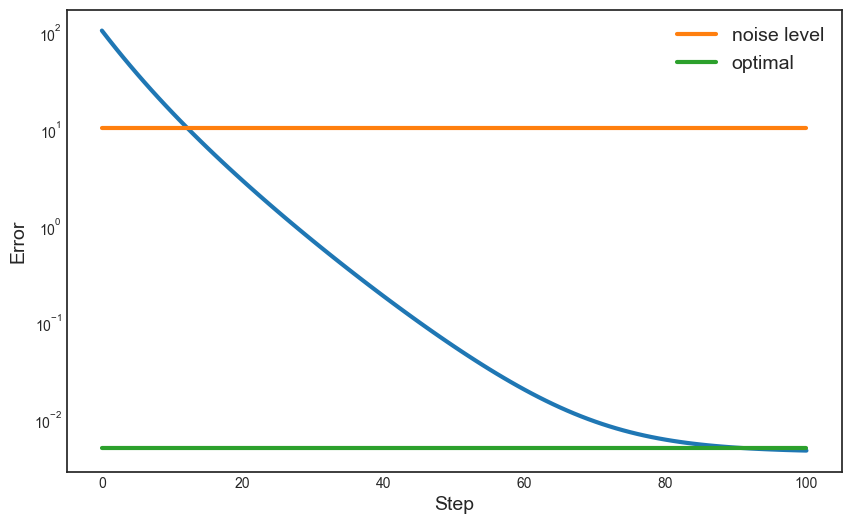

In [18]:
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [np.linalg.norm(noise)**2]*len(xs),
        label='noise level')
plt.plot(range(len(xs)), [least_squares(A,b,x_opt)]*len(xs),
        label='optimal')
plt.legend();

### Convergência em Domínio



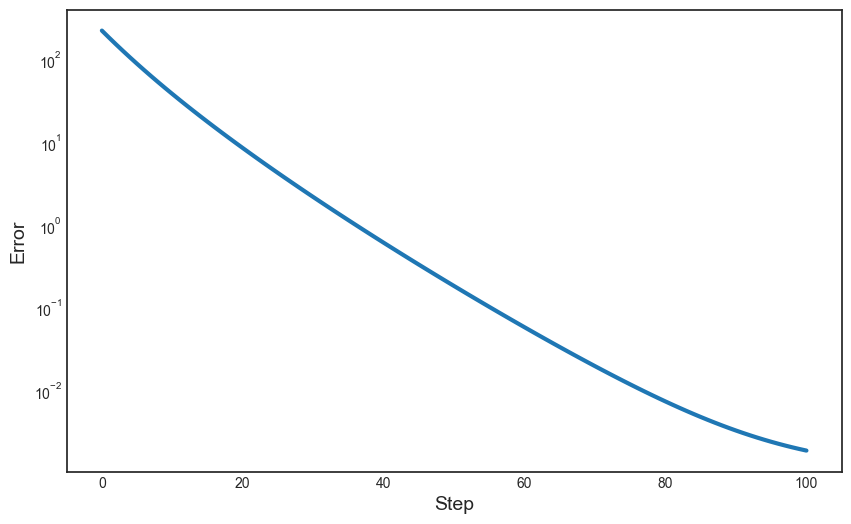

In [19]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])

### Caso subdeterminado $m < n$

No caso subdeterminado, o objetivo dos mínimos quadrados inevitavelmente não é fortemente convexo, uma vez que $A^\top A$ é uma matriz com deficiência de classificação e, portanto, $\lambda_{\mathrm{min}}(A^\top A)=0.$
é uma matriz de classificação deficiente e, portanto,

In [20]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
b = np.random.normal(0, 1, m)
# The least norm solution is given by the pseudo-inverse
x_opt = np.linalg.pinv(A).dot(b)
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)

Resultados.

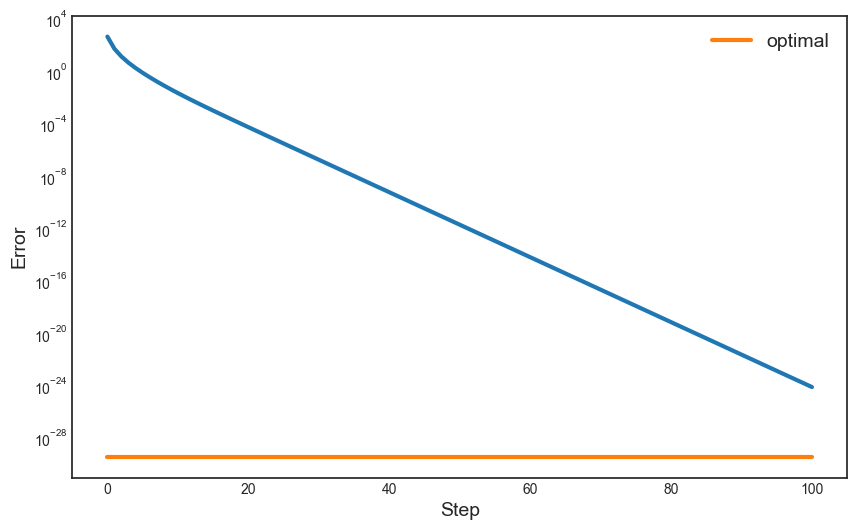

In [21]:
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [least_squares(A,b,x_opt)]*len(xs),
        label='optimal')
plt.legend();

Embora reduzamos rapidamente o erro, na verdade não convergimos no domínio para a solução de menor norma. Isso ocorre simplesmente porque a função não é mais fortemente convexa no caso subdeterminado.

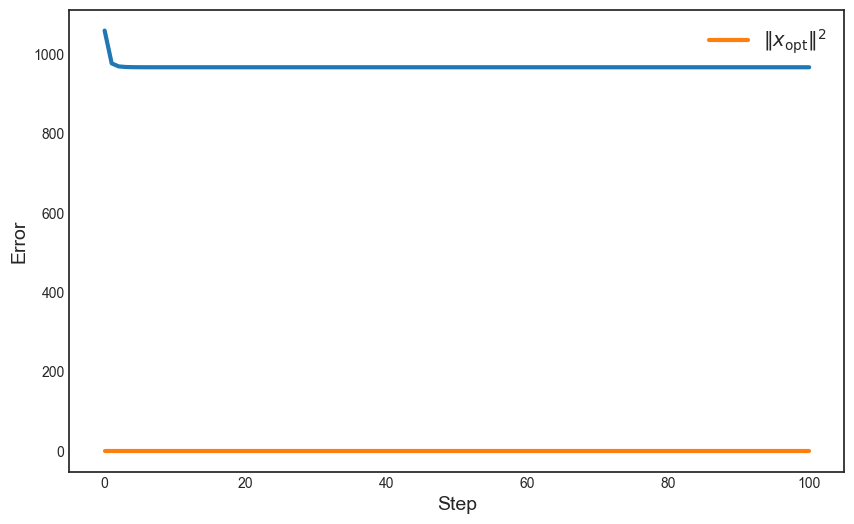

In [22]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
         label='$|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend();

### $l_{2}$- mínimos quadrados regularizados

No caso subdeterminado, muitas vezes é desejável restaurar a convexidade forte da função objetivo adicionando uma penalidade $\ell_2^2$, também conhecida como regularização de Tikhonov , regularização $\ell_2$ ou decaimento de peso .
-penalidade, também conhecida como
-regularização, ou

$$\frac1{2m}\|Ax-b\|^2 + \frac{\alfa}2\|x\|^2$$
 
 

Nota: Com esta modificação o objetivo é novamente $\alpha$-fortemente convexo.
-fortemente convexo novamente.

In [23]:
def least_squares_l2(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + (alpha/2) * x.dot(x)

def least_squares_l2_gradient(A, b, x, alpha=0.1):
    return least_squares_gradient(A, b, x) + alpha * x

Vamos criar uma instância de mínimos quadrados.

In [24]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
b = A.dot(np.random.normal(0, 1, n))
objective = lambda x: least_squares_l2(A, b, x)
gradient = lambda x: least_squares_l2_gradient(A, b, x)

Observe que podemos encontrar a solução ótima para o problema de otimização na forma fechada, mesmo sem executar a descida do gradiente, calculando $x_{\mathrm{opt}}=(A^\top+\alpha I)^{-1}A^\top b.$ Verifique se este ponto é realmente ótimo.
Por favor, verifique se este ponto é realmente o ideal.

In [25]:
x_opt = np.linalg.inv(A.T.dot(A) + 0.1*np.eye(1000)).dot(A.T).dot(b)

Veja como funciona a descida gradiente.

In [26]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, gradient)

Nós planejamos a descida.

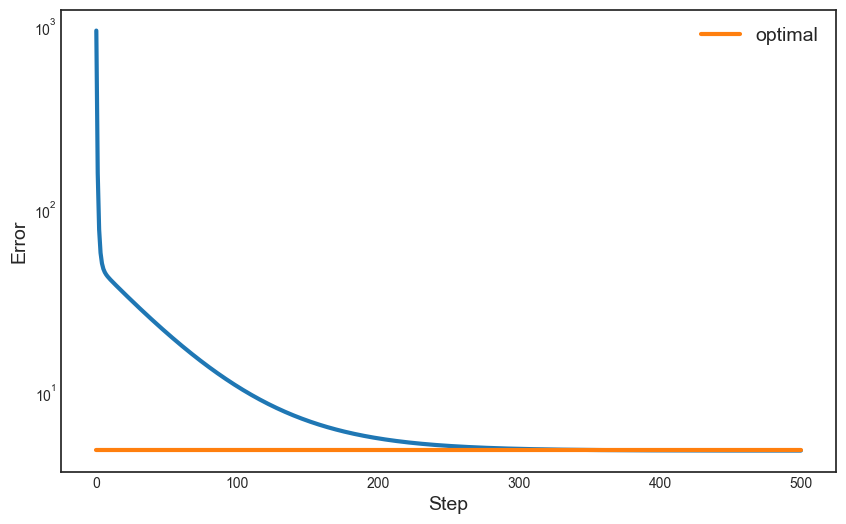

In [27]:
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [least_squares_l2(A,b,x_opt)]*len(xs),
        label='optimal')
plt.legend();

Você vê que o erro não diminui abaixo de um certo nível devido ao termo de regularização. Isso não é ruim. Na verdade, o termo de regularização resulta em uma convexidade forte , o que leva à convergência no domínio novamente:

In [28]:
xs = gradient_descent(x0, [0.1]*500, gradient)

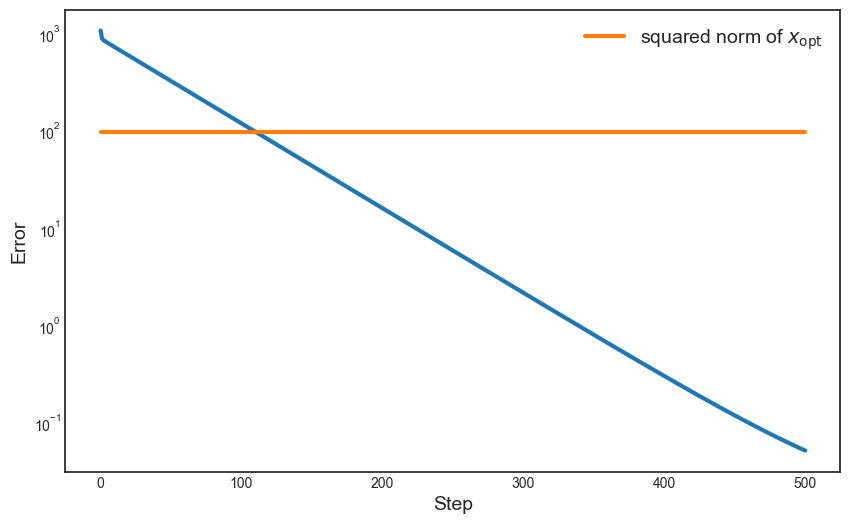

In [29]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
        label='squared norm of $x_{\mathrm{opt}}$')
plt.legend();

### A Magia da Regularização Implícita


Às vezes, simplesmente executar uma descida de gradiente a partir de um ponto inicial adequado tem um efeito regularizador por si só, sem introduzir um termo de regularização explícito .

Veremos isso abaixo, onde revisitamos o objetivo de mínimos quadrados não regularizados, mas inicializamos a descida do gradiente a partir da origem em vez de um ponto gaussiano aleatório.

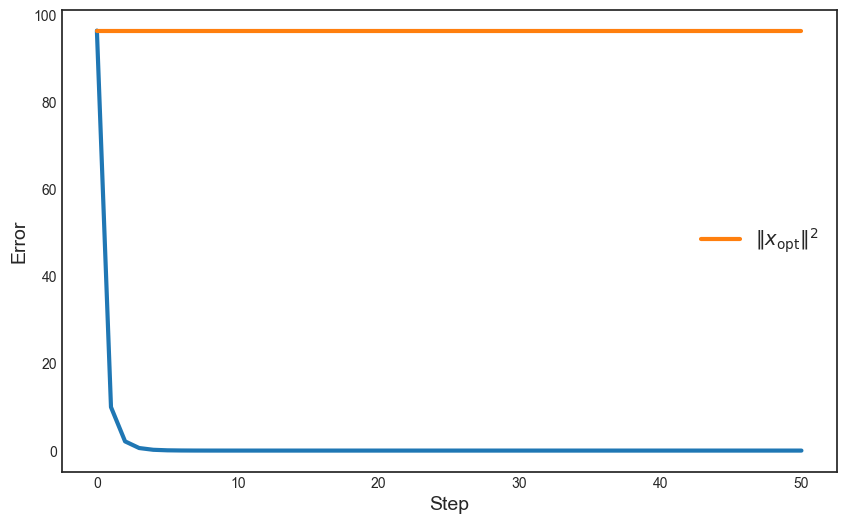

In [30]:
# We initialize from 0
x0 = np.zeros(n)
# Note this is the gradient w.r.t. the unregularized objective!
gradient = lambda x: least_squares_gradient(A, b, x)
xs = gradient_descent(x0, [0.1]*50, gradient)
error_plot([np.linalg.norm(x_opt-x)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
         label='$|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend();

Incrível! Convergimos para a solução da norma mínima!

A regularização implícita é um fenômeno profundo e um tópico de pesquisa ativo em aprendizagem e otimização. É emocionante ver isso acontecer neste problema simples de mínimos quadrados!

### 6. LASSO

LASSO é o nome da regressão de mínimos quadrados regularizada por $\ell_1$:
-regressão de mínimos quadrados regularizada:

$$\frac1{2m}\|Ax-b\|^2 + \alfa\|x\|_1$$
 

Veremos que o LASSO é capaz de encontrar soluções esparsas , caso existam. Essa é uma motivação comum para o uso de um regularizador $\ell_1$.
-regulador.

In [31]:
def lasso(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + alpha * np.linalg.norm(x, 1)

def ell1_subgradient(x):
    """Subgradient of the ell1-norm at x."""
    g = np.ones(x.shape)
    g[x < 0.] = -1.0
    return g

def lasso_subgradient(A, b, x, alpha=0.1):
    """Subgradient of the lasso objective at x"""
    return least_squares_gradient(A, b, x) + alpha*ell1_subgradient(x)

In [32]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
x_opt = np.zeros(n)
x_opt[:10] = 1.0
b = A.dot(x_opt)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, lambda x: lasso_subgradient(A, b, x))

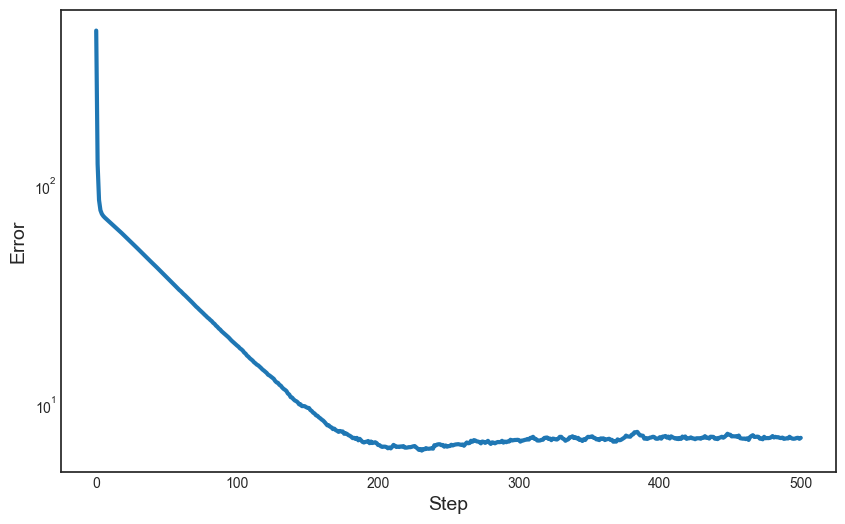

In [33]:
error_plot([lasso(A, b, x) for x in xs])

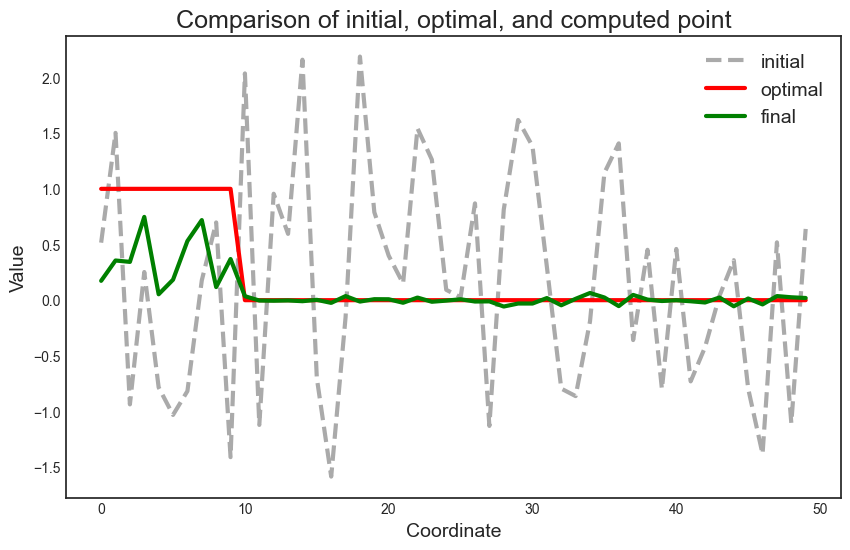

In [34]:
plt.figure()
plt.title('Comparison of initial, optimal, and computed point')
idxs = range(50)
plt.plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial')
plt.plot(idxs, x_opt[idxs], 'r-', label='optimal')
plt.plot(idxs, xs[-1][idxs], 'g-', label='final')
plt.xlabel('Coordinate')
plt.ylabel('Value')
plt.legend();

Como prometido, o LASSO identifica corretamente as coordenadas significativas da solução ótima. É por isso que, na prática, o LASSO é uma ferramenta popular para seleção de recursos.

Experimente este gráfico para inspecionar outros pontos ao longo do caminho, por exemplo, o ponto que atinge o menor valor objetivo. Por que o valor objetivo aumenta mesmo que continuemos a obter soluções melhores?

### 7. Suport Vector Machines (Máquinas de Vetores de Suporte)

Em um problema de classificação linear, recebemos $m$ pontos rotulados $(a_i, y_i)$ e desejamos encontrar um hiperplano dado por um ponto $x$ que os separa de modo que
pontos rotulados
e desejamos encontrar um hiperplano dado por um ponto
que os separa de modo que

quando
, e
quando
Quanto menor a norma $|x|$, maior a margem entre instâncias positivas e negativas. Portanto, faz sentido incluir um regularizador que penalize normas grandes. Isso nos leva ao objetivo.
quanto maior o

$$\frac 1m \soma_{i=1}^m \máx\{1-y_i(a_i^\top x), 0\} + \frac{\alfa}2\|x\|^2$$
 
 
 


In [35]:
def hinge_loss(z):
    return np.maximum(1.-z, np.zeros(z.shape))

def svm_objective(A, y, x, alpha=0.1):
    """SVM objective."""
    m, _ = A.shape
    return np.mean(hinge_loss(np.diag(y).dot(A.dot(x))))+(alpha/2)*x.dot(x)

In [36]:
z = np.linspace(-2, 2, 100)

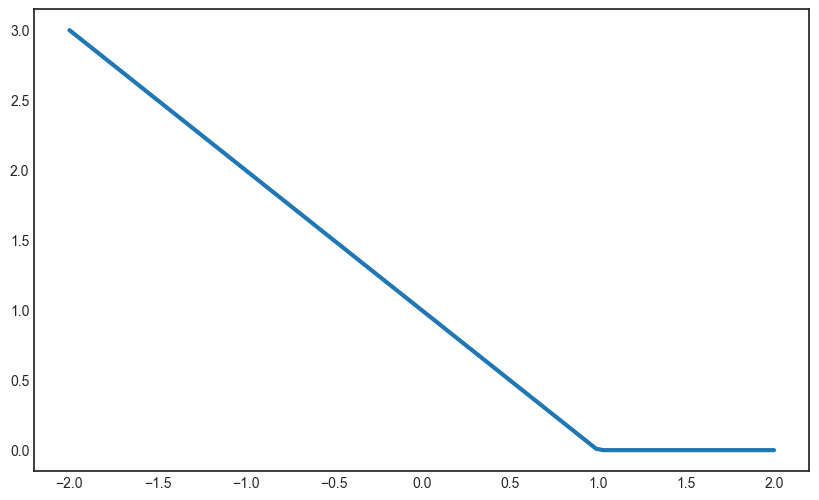

In [37]:
plt.figure()
plt.plot(z, hinge_loss(z));

In [38]:
def hinge_subgradient(z):
    g = np.zeros(z.shape)
    g[z < 1] = -1.
    return g

def svm_subgradient(A, y, x, alpha=0.1):
    g1 = hinge_subgradient(np.diag(y).dot(A.dot(x)))
    g2 = np.diag(y).dot(A)
    return g1.dot(g2) + alpha*x

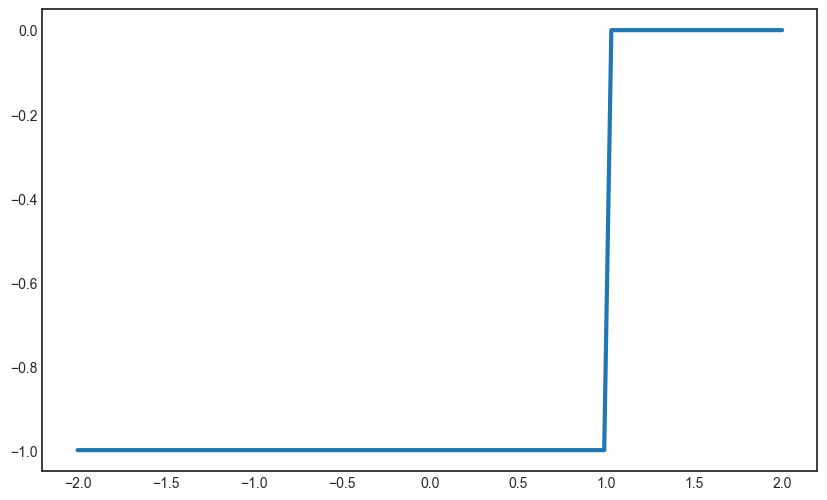

In [39]:
plt.figure()
plt.plot(z, hinge_subgradient(z));

In [40]:
m, n = 1000, 100
A = np.vstack([np.random.normal(0.1, 1, (m//2, n)),
               np.random.normal(-0.1, 1, (m//2, n))])
y = np.hstack([np.ones(m//2), -1.*np.ones(m//2)])
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.01]*100, 
                      lambda x: svm_subgradient(A, y, x, 0.05))

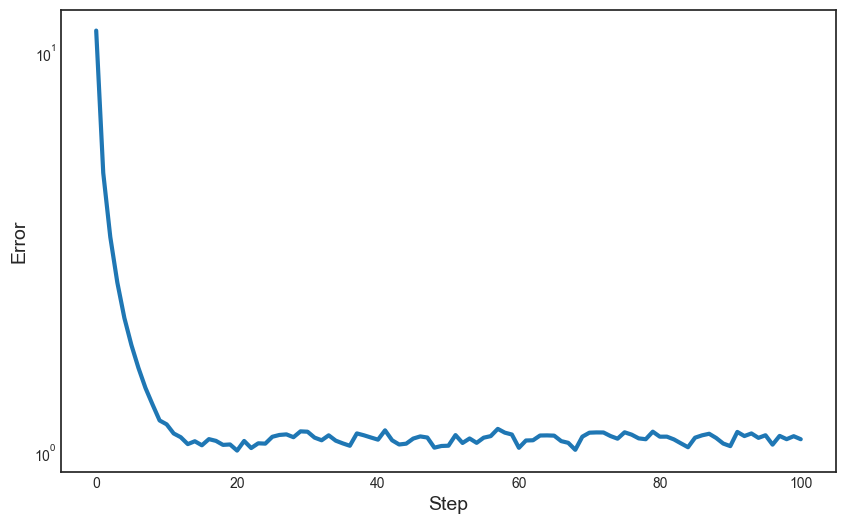

In [41]:
error_plot([svm_objective(A, y, x) for x in xs])

Vamos ver se a média das soluções nos dá um valor de função melhorado.

In [42]:
xavg = 0.0
for x in xs:
    xavg += x
svm_objective(A, y, xs[-1]), svm_objective(A, y, xavg/len(xs))

(1.0769128755009647, 0.9361096469610302)

Também podemos analisar a precisão do nosso modelo linear para prever os rótulos. A partir da forma como definimos os dados, podemos observar que o vetor de todos os uns é o classificador com maior precisão no limite de dados infinitos (m muito grande). Para um conjunto de dados finito, a precisão pode ser ainda maior devido a flutuações aleatórias.
). Para um conjunto de dados finito, a precisão pode ser ainda maior devido a flutuações aleatórias.

In [43]:
def accuracy(A, y, x):
    return np.mean(np.diag(y).dot(A.dot(x))>0)

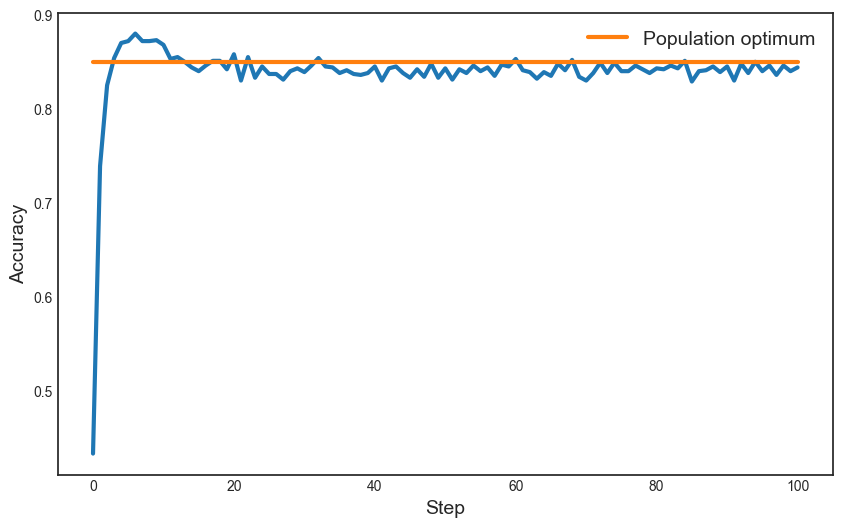

In [44]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.plot(range(len(xs)), [accuracy(A, y, x) for x in xs])
plt.plot(range(len(xs)), [accuracy(A, y, np.ones(n))]*len(xs),
        label='Population optimum')
plt.legend();

Percebemos que a precisão aumenta muito cedo e cai um pouco à medida que treinamos por muito tempo.

### 7. Estimativa de covariância inversa esparsa

Dada uma matriz semidefinida positiva $S\in\mathbb{R}^{n\times n}$, a função objetivo na estimativa de covariância inversa esparsa é a seguinte:
a função objetivo na estimativa de covariância inversa esparsa é a seguinte:

$$ \min_{X\in\mathbb{R}^{n\vezes n}, X\succeq 0} \langle S, X\rangle - \log\det(X) + \alpha\|X\|_1$$
 

Aqui, definimos $$\langle S, X\rangle = \mathrm{trace}(S^\top X)$$ e $$|X| 1 = \sum {ij}|X_{ij}|.$$
e $$|X|

Normalmente, pensamos na matriz $S$ como uma matriz de covariância de exemplo de um conjunto de vetores $a_1,\dots, a_m,$ definido como: $$ S = \frac1{m-1}\sum_{i=1}^n a_ia_i^\top $$ O exemplo também destaca a utilidade da diferenciação automática, conforme fornecida pelo pacote que usaremos regularmente. Em uma aula posterior, entenderemos exatamente como a diferenciação automática funciona. Por enquanto, trataremos apenas como uma caixa-preta que nos fornece gradientes.
como uma matriz de covariância de amostra de um conjunto de vetores
definido como:
 
 
O exemplo também destaca a utilidade da diferenciação automática, conforme fornecida peloautograd

In [45]:
np.random.seed(1337)

In [46]:
def sparse_inv_cov(S, X, alpha=0.1):
    return (np.trace(S.T.dot(X))
            - np.log(np.linalg.det(X))
            + alpha * np.sum(np.abs(X)))

In [47]:
n = 5
A = np.random.normal(0, 1, (n, n))
S = A.dot(A.T)
objective = lambda X: sparse_inv_cov(S, X)
# autograd provides a "gradient", yay!
gradient = grad(objective)

Também precisamos nos preocupar com a projeção no cone semidefinido positivo, que corresponde ao truncamento de autovalores.

In [48]:
def projection(X):
    """Projection onto positive semidefinite cone."""
    es, U = np.linalg.eig(X)
    es[es<0] = 0.
    return U.dot(np.diag(es).dot(U.T))

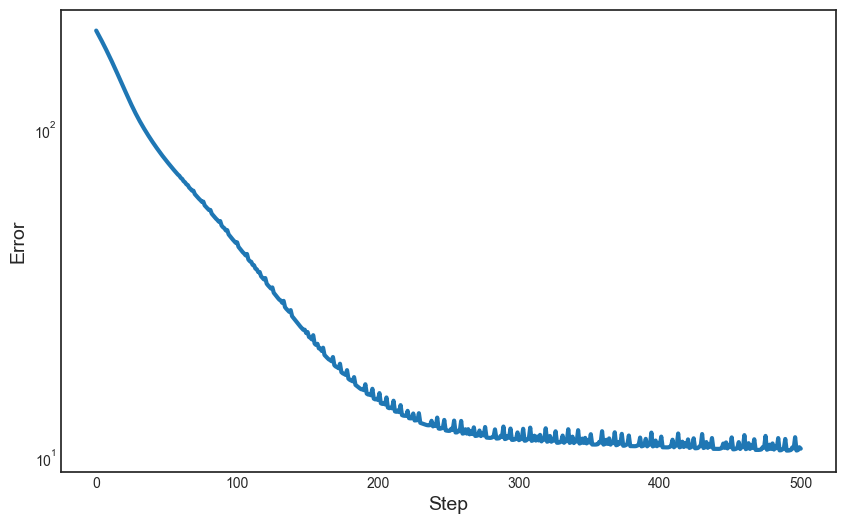

In [49]:
A0 = np.random.normal(0, 1, (n,n))
X0 = A0.dot(A0.T)
Xs = gradient_descent(X0, [0.01]*500, gradient, projection)
error_plot([objective(X) for X in Xs])

### Enlouquecendo com a autograd

Só por diversão, vamos analisar um exemplo maluco abaixo. Podemos usá-lo autogradnão apenas para obter gradientes para objetivos naturais, mas também, em princípio, para ajustar hiperparâmetros do nosso otimizador, como o agendamento do tamanho do passo.

Abaixo, vemos como podemos encontrar melhores esquemas de taxa de aprendizado de 10 passos para otimizar uma equação quadrática. Isso serve principalmente para fins ilustrativos (embora alguns pesquisadores estejam explorando esse tipo de ideia com mais seriedade).

In [50]:
x0 = np.random.normal(0, 1, 1000)

In [51]:
def f(x):
    return 0.5*np.dot(x,x)

def optimizer(steps):
    """Optimize a quadratic with the given steps."""
    xs = gradient_descent(x0, steps, grad(f))
    return f(xs[-1])

A função optimizeré uma função não diferenciável de sua entrada steps. No entanto, autogradfornecerá um gradiente que podemos aplicar à descida do gradiente. Ou seja, estamos ajustando a descida do gradiente com a descida do gradiente.

In [52]:
grad_optimizer = grad(optimizer)

In [53]:
initial_steps = np.abs(np.random.normal(0, 0.1, 10))
better_steps = gradient_descent(initial_steps, [0.001]*500, grad_optimizer)

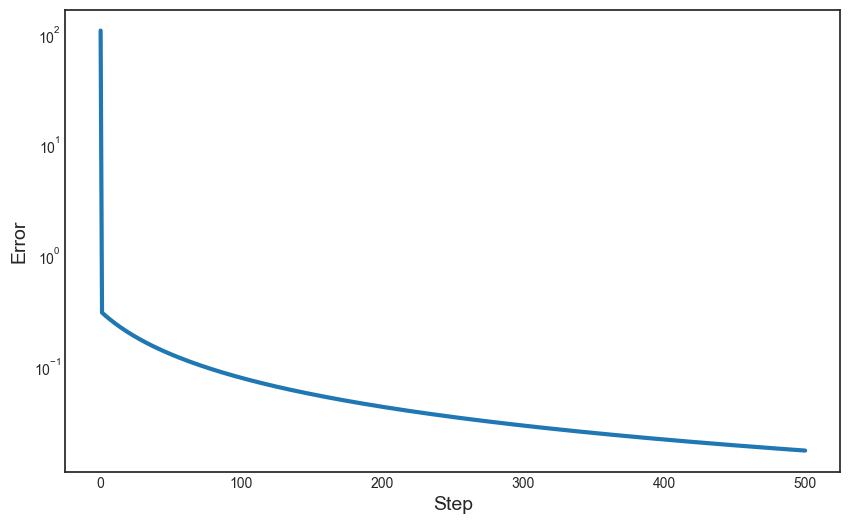

In [54]:
error_plot([optimizer(steps) for steps in better_steps])

Como podemos ver, os gráficos de taxa de aprendizagem melhoram drasticamente com o tempo. É claro que já sabemos, pelo primeiro exemplo, que existe um gráfico de tamanho de passo que converge em um passo. Curiosamente, o último gráfico que encontramos aqui não se parece em nada com o que poderíamos esperar:

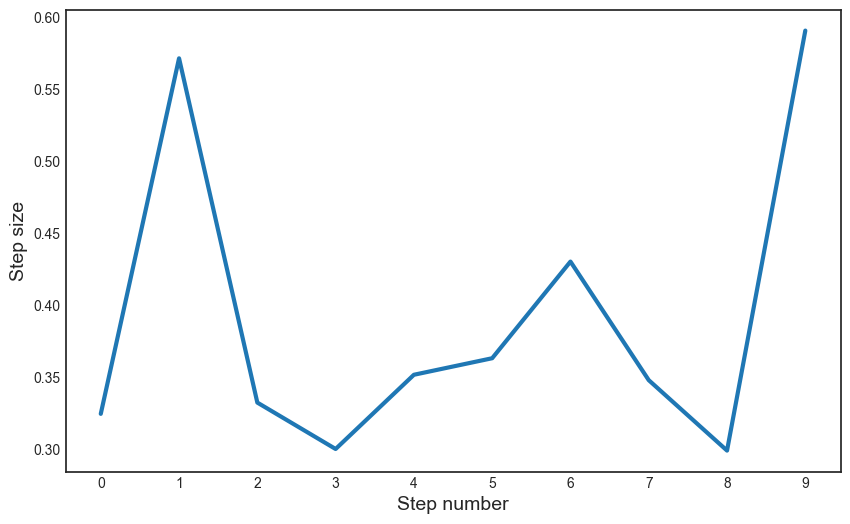

In [55]:
plt.figure()
plt.xticks(range(len(better_steps[-1])))
plt.ylabel('Step size')
plt.xlabel('Step number')
plt.plot(range(len(better_steps[-1])), better_steps[-1]);